6/16/2021

all normal tissue finder - make a Bar chart of # vocabularies by tissue type


In [1]:
# basic packages
import os, glob
import pandas as pd
import numpy as np; np.random.seed(0)
import itertools
from collections import Counter, defaultdict
import time
# Import tools needed for visualization
from upsetplot import plot, from_memberships
import seaborn as sns; 
import matplotlib.pyplot as plt

plt.style.use('seaborn-paper')
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

In [2]:
save_dir = '../data/processed/fig4_modelling/vocab_sum/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [3]:
# TISSUE = 'GDSD0'

normal_tissues = ['Airway','Astrocytes','Bladder','Colon','Esophageal','GDSD6','GM12878','HMEC','Melanocytes','Ovarian',
'Pancreas','Prostate','Renal','Thyroid','Uterine']
normal_tissues_dict = dict(zip(normal_tissues,range(len(normal_tissues))))

# 1. Tissue specific transcription factors

- manual annotation
- cell type specific expressed tfs (HOCOMOCO)
- modelling tfs

## A. cell type specific expressed tfs (HOCOMOCO)

In [42]:
# tfs 
tf_annon_df = pd.read_csv('../data/external/HOCOMOCOv11_annotation.csv',index_col=0)
tf_annon_df['id_trim'] = tf_annon_df['id'] + '.pwm.trim'
tf_name_to_id_dict = pd.Series(tf_annon_df.id_trim.values, index=tf_annon_df.tf.values).to_dict()
tf_id_to_name_dict = pd.Series(tf_annon_df.tf.values, index=tf_annon_df.id_trim.values).to_dict()
print(len(tf_name_to_id_dict))

679


In [32]:
THRES=1
rna_tpm_file = '../data/interim/rna/tissue_tpm_sym.csv'
rna_df = pd.read_csv(rna_tpm_file,index_col=0)
rna_df_tf = rna_df.loc[tf_annon_df.tf.values,normal_tissues]
# rna_df_log = np.log2(rna_df+1e-2)
# rna_df_norm = as.data.frame(scale(rna_df_log, center = TRUE, scale = TRUE))
# head(rna_df_norm)

In [47]:
num_tissues_per_tf = pd.DataFrame(rna_df_tf>THRES).sum(axis=1)
# number of unique tfs
unique_tfs = num_tissues_per_tf.index.values[num_tissues_per_tf==1]
print(unique_tfs.shape)


(70,)


In [55]:
unique_tf_to_tissue = pd.DataFrame(rna_df_tf>THRES).reset_index().melt('index')
unique_tf_to_tissue = unique_tf_to_tissue[unique_tf_to_tissue['value']]
unique_tf_to_tissue = unique_tf_to_tissue[unique_tf_to_tissue['index'].isin(unique_tfs)]
unique_tf_to_tissue = unique_tf_to_tissue[['index','variable']]
unique_tf_to_tissue.columns = ['tf','cell_type']
unique_tf_to_tissue.cell_type.value_counts()

Astrocytes     24
Melanocytes    13
Prostate       10
GM12878        10
GDSD6           4
Airway          4
Esophageal      1
Colon           1
HMEC            1
Ovarian         1
Thyroid         1
Name: cell_type, dtype: int64

### manual annotation - from literature

In [119]:
#get tfs
tf_df_manual = pd.read_csv('../data/external/transcription_factor_info_061521.csv').drop_duplicates()
# TFS = sorted(set(tf_df[tf_df['cell_type']=='Keratinocytes']["tf"]))##### DIFFERENT FOR EACH TISSUE
# print(len(TFS))
# print(TFS)


In [120]:
tf_df_manual.cell_type.value_counts()

GDSD6          97
HMEC           76
Airway         39
Melanocytes    28
Renal          27
Colon          25
Astrocytes     19
GM12878        18
Ovarian        16
Esophageal     15
Pancreas       14
Uterine        12
Thyroid        11
Bladder        10
Prostate        7
Melanoma        4
Name: cell_type, dtype: int64

In [121]:
tf_df = pd.concat([unique_tf_to_tissue,tf_df_manual],sort=True).drop_duplicates()
tf_df.cell_type.value_counts()

GDSD6          99
HMEC           77
Airway         42
Astrocytes     39
Melanocytes    37
Renal          27
Colon          26
GM12878        24
Prostate       17
Ovarian        17
Esophageal     16
Pancreas       14
Thyroid        12
Uterine        12
Bladder        10
Melanoma        4
Name: cell_type, dtype: int64

# 2 helper functions

In [89]:
pd.read_csv(os.path.join(vocab_dir,'expr_'+tissue+'_pro_pro_vocab_info.csv' ))

,Unnamed: 0,chr,start,stop,TSS,chr_m,start_m,stop_m,id_trim,score,strand,tf,vocab,genes,tissue
0,1854207,chr6,136859957,136862457,MAP7,chr6,136860191,136860212,ARI3A_HUMAN.H11MO.0.D.pwm.trim,10.933418,-,ARID3A,ARID3A::STAT3,MAP7,GDSD6
1,1854270,chr6,136859957,136862457,MAP7,chr6,136860329,136860338,STAT3_HUMAN.H11MO.0.A.pwm.trim,10.995572,+,STAT3,ARID3A::STAT3,MAP7,GDSD6
2,67379,chr1,27481472,27483972,SLC9A1,chr1,27481888,27481892,ARI5B_HUMAN.H11MO.0.C.pwm.trim,6.233325,-,ARID5B,ARID5B::ATF7,ACADVL|ANKRD11|ANXA2|CTDNEP1|ELP5|OXSR1|SLC9A1...,GDSD6
3,67390,chr1,27481472,27483972,SLC9A1,chr1,27481907,27481911,ARI5B_HUMAN.H11MO.0.C.pwm.trim,6.233325,+,ARID5B,ARID5B::ATF7,ACADVL|ANKRD11|ANXA2|CTDNEP1|ELP5|OXSR1|SLC9A1...,GDSD6
4,67400,chr1,27481472,27483972,SLC9A1,chr1,27481910,27481914,ARI5B_HUMAN.H11MO.0.C.pwm.trim,6.233325,+,ARID5B,ARID5B::ATF7,ACADVL|ANKRD11|ANXA2|CTDNEP1|ELP5|OXSR1|SLC9A1...,GDSD6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33230,1886295,chr7,75919861,75922361,HSPB1,chr7,75921270,75921291,ZN467_HUMAN.H11MO.0.C.pwm.trim,13.324705,-,ZNF467,ZNF335::ZNF467,BCO2|CALML5|CDC42SE1|DSG2|EPHA2|FLAD1|HSPB1|ID...,GDSD6
33231,1886391,chr7,75919861,75922361,HSPB1,chr7,75921275,75921296,ZN467_HUMAN.H11MO.0.C.pwm.trim,19.176265,-,ZNF467,ZNF335::ZNF467,BCO2|CALML5|CDC42SE1|DSG2|EPHA2|FLAD1|HSPB1|ID...,GDSD6
33232,1886457,chr7,75919861,75922361,HSPB1,chr7,75921276,75921297,ZN467_HUMAN.H11MO.0.C.pwm.trim,9.985416,-,ZNF467,ZNF335::ZNF467,BCO2|CALML5|CDC42SE1|DSG2|EPHA2|FLAD1|HSPB1|ID...,GDSD6
33233,1886985,chr7,75919861,75922361,HSPB1,chr7,75921337,75921358,ZN467_HUMAN.H11MO.0.C.pwm.trim,12.404595,+,ZNF467,ZNF335::ZNF467,BCO2|CALML5|CDC42SE1|DSG2|EPHA2|FLAD1|HSPB1|ID...,GDSD6


In [105]:
def get_other_vocab_word(row, next_row):
    if row['vocab']!=next_row['vocab']:
        return False
    
    vocab_word = set(row['tf'])
    vocab_set = set(row['vocab'].split('::'))
    other_vocab = list(vocab_set -  vocab_word)[0]
    return other_vocab == next_row['tf']

def check_distance(row,next_row,max_dist=MAX_DIST):
    if row['chr_m']==next_row['chr_m']:
        if row['stop_m']<next_row['start_m']:
            tot_dist = next_row['stop_m'] - row['start_m']
            btn_dist = next_row['start_m'] - row['stop_m']
            return (tot_dist < max_dist), tot_dist, btn_dist
    return False,-1,-1

def check_tissue(row,next_row,tfs=TFS):
    if (row['tf'] in tfs) & (next_row['tf'] in tfs):
        return 'both'
    elif (row['tf'] in tfs) | (next_row['tf'] in tfs):
        return 'one'    
    else:
        return 'none'
    
def get_hits(vocab_file,tfs=TFS):
    print('**** reading', vocab_file)
    vocab_df = pd.read_csv(vocab_file)
    print(vocab_df.shape)
    idx = 0
    idx_hits = 0
    results_dict = {}
    while idx < (vocab_df.shape[0]-1):
        # look at next 
        row = vocab_df.iloc[idx,:]
        next_row = vocab_df.iloc[idx+1,:]

        check_vocab_pair = get_other_vocab_word(row,next_row)
        check_dist,tot_dist, btn_dist = check_distance(row, next_row)
        check_tissue_tf = check_tissue(row,next_row,tfs)
        if (check_dist and check_vocab_pair):
    #         print('hi',idx)
    #         print(row)
    #         print(next_row)

            results_dict[idx_hits] = {'vocab_pair':row['vocab'],'tot_dist':tot_dist,'btn_dist':btn_dist,
                                      'chr':row['chr'],'start':row['start_m'],'stop':next_row['stop_m'], 
                                      'vocab1':row['tf'],'vocab1_start':row['start_m'], 'vocab1_stop': row['stop_m'],
                                      'vocab2':next_row['tf'],'vocab2_start':next_row['start_m'], 'vocab2_stop': next_row['stop_m'],
                                      'genes':row['genes'],'num_genes':len(row['genes'].split('|')), 'tissue':row['tissue'],
                                     'check_tissuetf':check_tissue_tf}
            idx_hits+=1

        idx+=1
    print('num_hits',idx_hits)
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
    return results_df
    
def filter_results(results_df,min_hits_per_vocab=10):
    print('shape', results_df.shape)
    vocab_counts = results_df.vocab_pair.value_counts()
    print('original num vocab',vocab_counts.shape[0])
    vocab_to_include = vocab_counts[vocab_counts>min_hits_per_vocab].index.values
    print('filt num vocab',vocab_to_include.shape[0])
    
    results_df_filt = results_df[results_df.vocab_pair.isin(vocab_to_include)]
    return results_df_filt

def get_counts(results_df, label):
    counts_df = pd.DataFrame(results_df.vocab_pair.value_counts())
    counts_df.columns = ['num_instance']
    counts_df['label']=label
    return counts_df   


def get_vocabs(tissue, tfs, save=True,filter_thres = ['none']):
    """
    pipeline to get vocabs
    filter thres is a list of 'none' or #'both' # 'one'#'none','one',
    """
    tfs = sorted(set(tfs))
    print(tissue, 'num tfs', len(tfs))
    print(tfs)
    
    pro_pro_file = os.path.join(vocab_dir,'expr_'+tissue+'_pro_pro_vocab_info.csv' )
    loop_loop_file = os.path.join(vocab_dir,'expr_'+tissue+'_loop_loop_vocab_info.csv' )

    #Takes awhile
    # Step 1. get expressiod and stability for specific config regions
    results_expr_pro_pro = get_hits(pro_pro_file, tfs=tfs)
    results_expr_loop_loop = get_hits(loop_loop_file, tfs=tfs)
    
    
    # Step 2: raw stats
    print('pre genomic instance filter')
    motifs_pro_pro = sorted(set(list(results_expr_pro_pro.vocab1.unique())+list(results_expr_pro_pro.vocab2.unique())))
    print('num motifs in pro_pro', len(motifs_pro_pro))
    print(motifs_pro_pro)
    motifs_loop_loop = sorted(set(list(results_expr_loop_loop.vocab1.unique())+list(results_expr_loop_loop.vocab2.unique())))
    print('num motifs in loop_loop', len(motifs_loop_loop))
    print(motifs_loop_loop)
    print('num vocab in expression enrichment (pro-pro region): ', results_expr_pro_pro.vocab_pair.unique().shape[0])
    # print('num vocab in expression enrichment intersected with stability (pro-pro region): ', results_stability_pro_pro.vocab_pair.unique().shape[0])
    # print(results_stability_pro_pro.vocab_pair.unique())
    print('num vocab in expression enrichment (loop-loop region): ', results_expr_loop_loop.vocab_pair.unique().shape[0])
    # print('num vocab in expression enrichment intersected with stability (loop-loop region): ', results_stability_loop_loop.vocab_pair.unique().shape[0])
    # print(results_stability_loop_loop.vocab_pair.unique())

    # step 3: filter expression enriched vocab words if then have at least 10 genomic instances then get stats
    results_expr_pro_pro = filter_results(results_expr_pro_pro,min_hits_per_vocab=10)
    results_expr_loop_loop = filter_results(results_expr_loop_loop,min_hits_per_vocab=10)
    print('post genomic instance filter')
    print('num vocab in expression enrichment (pro-pro region): ', results_expr_pro_pro.vocab_pair.unique().shape[0])
    # print('num vocab in expression enrichment intersected with stability (pro-pro region): ', results_stability_pro_pro.vocab_pair.unique().shape[0])
    print(results_expr_pro_pro.vocab_pair.unique())
    print('num vocab in expression enrichment (loop-loop region): ', results_expr_loop_loop.vocab_pair.unique().shape[0])
    # print('num vocab in expression enrichment intersected with stability (loop-loop region): ', results_stability_loop_loop.vocab_pair.unique().shape[0])
    print(results_expr_loop_loop.vocab_pair.unique())


    # step 4: filter expr vocab words based on whether there is they are annotated for skin
    print(results_expr_pro_pro[['vocab_pair','check_tissuetf']].drop_duplicates().check_tissuetf.value_counts())
    print(results_expr_loop_loop[['vocab_pair','check_tissuetf']].drop_duplicates().check_tissuetf.value_counts())
    
    results_expr_pro_pro_tissue = results_expr_pro_pro[results_expr_pro_pro.check_tissuetf.isin(filter_thres)]
    print('pro-pro region')
    print('total vocab:',results_expr_pro_pro.vocab_pair.unique().shape[0],'tissue annon vocab:', results_expr_pro_pro_tissue.vocab_pair.unique().shape[0])
    print(results_expr_pro_pro_tissue.vocab_pair.unique())

    results_expr_loop_loop_tissue = results_expr_loop_loop[results_expr_loop_loop.check_tissuetf.isin(filter_thres)]
    print('loop-loop region')
    print('total vocab:',results_expr_loop_loop.vocab_pair.unique().shape[0],'tissue annon vocab:', results_expr_loop_loop_tissue.vocab_pair.unique().shape[0])
    print(results_expr_loop_loop_tissue.vocab_pair.unique())



    # step 5: add in stability scores vocab pairs that pass the genomic instance filter and get genomic instance counts
    vocab_summary_df = pd.concat([# get_counts(results_stability_pro_pro, 'stability_pro'),
                get_counts(results_expr_pro_pro_tissue, 'expr_pro_tissue'),
    #             get_counts(results_stability_loop_loop, 'stability_loop'),
                get_counts(results_expr_loop_loop_tissue, 'expr_loop_tissue')],axis=0)
    vocab_summary_df.index.set_names('vocab',inplace=True)
    vocab_summary_df.reset_index(inplace=True)
    vocab_summary_df = vocab_summary_df.groupby('vocab').agg({'num_instance':sum, 'label':'|'.join}).reset_index()
    vocab_summary_df['tissue']=tissue
    print(vocab_summary_df.label.value_counts())
    print('*****, number of vocab words', len(vocab_summary_df))
    # results_stability_loop_loop.vocab_pair.unique()

    # Saving..
    if save:
        vocab_summary_df.to_csv(os.path.join(save_dir, tissue+'_vocab_summary.csv'))
    
    return vocab_summary_df

# 3. Vocabulary genomic instances - running



In [78]:
# global variables
vocab_dir = '../data/processed/fig4_modelling/tf_tf_pairs/'
MAX_DIST=135


In [91]:
%%time
vocab_tissue_all = pd.DataFrame()
for tissue in normal_tissues:
    print('==============================================================')
    tfs = tf_df[tf_df.cell_type==tissue].tf.values
#     if os.path.exists(os.path.join(save_dir, tissue+'_vocab_summary.csv')):
#         print('skipped',tissue, 'ar')
    vocab_summary_df = get_vocabs(tissue, tfs, save=True,filter_thres = ['none'])
    
    vocab_tissue_all = pd.concat([vocab_tissue_all, vocab_summary_df])


Airway num tfs 43
['NR1D1' 'NR1D1' 'SIX2' 'TBX1' 'MYB' 'TP63' 'TTF' 'SOX2' 'FOXJ1' 'FANK1'
 'JAZF1' 'BNC1' 'ARNTL' 'FOSL1' 'HMGA2' 'SOX7' 'ETV5' 'KLF7' 'HSF2BP'
 'ETS1' 'SOX16' 'CEBPG' 'SNAI2' 'FOXA2' 'ID3' 'ETV4' 'NPAS2' 'MXD1'
 'ZNF185' 'KLF9' 'ZNF215' 'MYC' 'DR1' 'PAWR' 'TAF1D' 'HIF1A' 'HES2' 'E2F7'
 'CCRN4L' 'ZNF85' 'PRDM1' 'TFCP2L1' 'SPDEF']
**** reading ../data/processed/fig4_modelling/tf_tf_pairs/expr_Airway_pro_pro_vocab_info.csv
(8479, 15)
num_hits 1305
**** reading ../data/processed/fig4_modelling/tf_tf_pairs/expr_Airway_loop_loop_vocab_info.csv
(24010, 15)
num_hits 3079
pre genomic instance filter
num motifs in pro_pro 79
['ARID3A', 'ARID5B', 'ASCL2', 'BARX2', 'BATF', 'BCL11A', 'ESRRA', 'ETV3', 'FLI1', 'FOS', 'FOSB', 'FOSL1', 'FOSL2', 'FOXA1', 'FOXA2', 'FOXD1', 'FOXJ2', 'FOXK1', 'GLI3', 'GRHL1', 'HES7', 'HMGA1', 'HOXB2', 'HOXB3', 'IRF7', 'IRX2', 'IRX3', 'ISL1', 'JDP2', 'JUN', 'JUNB', 'JUND', 'KLF9', 'MAFB', 'MAFF', 'MAFK', 'MEIS1', 'MYBL2', 'NFATC1', 'NFATC4', 'NFE2L1', 'NFE

In [96]:
vocab_tissue_all.tissue.value_counts()
# no filtering

Ovarian        1080
Uterine         798
Prostate        733
GM12878         425
GDSD6           325
Esophageal      220
Astrocytes      211
Bladder          79
Melanocytes      78
Pancreas         68
Colon            56
Airway           44
Thyroid          43
Renal            36
HMEC             13
Name: tissue, dtype: int64

### redo some of them

In [107]:
tissue= 'HMEC'
tfs = tf_df[tf_df.cell_type==tissue].tf.values
tfs = list(tfs)+['ARID5B', 'ATF2', 'BACH1', 'BACH2', 'CEBPG', 'DDIT3', 'DLX1', 'FOS', 'FOSB', 'FOSL1', 'FOSL2', 'FOXA1', 'GLI3', 'HES7', 'HEY1', 'HLTF', 'HMGA1', 'HOXA10', 'HOXA5', 'HOXA9', 'HOXB2', 'HOXC13', 'HOXC6', 'HOXC8', 'IRF5', 'IRF7', 'IRX2', 'IRX3', 'JUN', 'JUNB', 'JUND', 'KLF9', 'LHX6', 'MAF', 'MAFF', 'MAFG', 'MAFK', 'MEIS3', 'MESP1', 'MNX1', 'MSX1', 'MSX2', 'NFATC1', 'NFE2L1', 'NFE2L2', 'NFIA', 'OSR2', 'PBX1', 'POU2F2', 'PPARG', 'RREB1', 'RUNX2', 'RUNX3', 'SIX1', 'SMAD4', 'SOX13', 'SP2', 'TCF7', 'TEAD3', 'TP53', 'TP63', 'TWIST1', 'UBP1', 'ZBTB18', 'ZBTB49', 'ZBTB6', 'ZFP28', 'ZNF134', 'ZNF18', 'ZNF331', 'ZNF41', 'ZNF467', 'ZNF490', 'ZNF502', 'ZNF554', 'ZNF563', 'ZNF667', 'ZNF816', 'ZNF85']+['ARID5B', 'ATF2', 'BACH1', 'BACH2', 'CEBPG', 'DDIT3', 'DLX1', 'FOS', 'FOSB', 'FOSL1', 'FOSL2', 'GLI3', 'HES7', 'HEY1', 'HLTF', 'HMGA1', 'HOXA10', 'HOXA5', 'HOXB2', 'HOXC6', 'HOXC8', 'IRF5', 'IRX2', 'IRX3', 'JUN', 'JUNB', 'JUND', 'KLF9', 'LHX6', 'MAF', 'MAFG', 'MAFK', 'MECOM', 'MEIS3', 'MESP1', 'MSX2', 'NFATC1', 'NFE2L1', 'NFE2L2', 'NFIA', 'OSR2', 'PBX1', 'POU2F2', 'RUNX2', 'RUNX3', 'SIX1', 'SMAD4', 'SOX13', 'SP2', 'TCF7', 'TP63', 'TWIST1', 'UBP1', 'ZBTB18', 'ZBTB49', 'ZBTB6', 'ZFP28', 'ZNF134', 'ZNF18', 'ZNF331', 'ZNF41', 'ZNF467', 'ZNF490', 'ZNF502', 'ZNF554', 'ZNF667', 'ZNF816', 'ZNF85']

#     if os.path.exists(os.path.join(save_dir, tissue+'_vocab_summary.csv')):
#         print('skipped',tissue, 'ar')
vocab_summary_df = get_vocabs(tissue, tfs, save=True,filter_thres = ['none', 'one','both'])



HMEC num tfs 147
['AFF3', 'ANKRD1', 'AR', 'ARID5B', 'ATF2', 'BACH1', 'BACH2', 'BARX2', 'BATF', 'BCL6B', 'CEBPG', 'CERS3', 'CHD1', 'CREB3L1', 'CSDC2', 'DDIT3', 'DLX1', 'DMRTA1', 'EHF', 'ELF5', 'ERG', 'ESR1', 'ESRRB', 'FLI1', 'FOS', 'FOSB', 'FOSL1', 'FOSL2', 'FOXA1', 'FOXC1', 'FOXL1', 'FOXQ1', 'GATA6', 'GLI3', 'GRHL1', 'HDAC9', 'HES2', 'HES7', 'HEY1', 'HEY2', 'HLTF', 'HMGA1', 'HNF4G', 'HOXA10', 'HOXA5', 'HOXA9', 'HOXB2', 'HOXC13', 'HOXC6', 'HOXC8', 'HOXD10', 'HOXD3', 'IRF5', 'IRF7', 'IRX2', 'IRX3', 'IRX4', 'JUN', 'JUNB', 'JUND', 'KLF4', 'KLF5', 'KLF9', 'LHX6', 'LMCD1', 'MAF', 'MAFF', 'MAFG', 'MAFK', 'MECOM', 'MEDX1', 'MEIS3', 'MESP1', 'MLF1IP', 'MNX1', 'MSX1', 'MSX2', 'MYB', 'MYBL1', 'MYC', 'NANOG', 'NFATC1', 'NFE2L1', 'NFE2L2', 'NFIA', 'NR5A2', 'OSR2', 'PAX9', 'PBX1', 'PGR', 'POU2F2', 'PPARA', 'PPARG', 'REST', 'RREB1', 'RUNX2', 'RUNX3', 'SIX1', 'SMAD4', 'SMYD1', 'SOX10', 'SOX13', 'SOX17', 'SOX2', 'SOX8', 'SP2', 'SPDEF', 'SREBF2', 'STAT3', 'STAT5', 'TAL1', 'TBX3', 'TCF15', 'TCF4', 'TCF7'

In [122]:
%%time
tissue= 'Uterine'
tfs = tf_df[tf_df.cell_type==tissue].tf.values
# tfs = list(tfs)+['ARID5B', 'ATF2', 'BACH1', 'BACH2', 'CEBPG', 'DDIT3', 'DLX1', 'FOS', 'FOSB', 'FOSL1', 'FOSL2', 'FOXA1', 'GLI3', 'HES7', 'HEY1', 'HLTF', 'HMGA1', 'HOXA10', 'HOXA5', 'HOXA9', 'HOXB2', 'HOXC13', 'HOXC6', 'HOXC8', 'IRF5', 'IRF7', 'IRX2', 'IRX3', 'JUN', 'JUNB', 'JUND', 'KLF9', 'LHX6', 'MAF', 'MAFF', 'MAFG', 'MAFK', 'MEIS3', 'MESP1', 'MNX1', 'MSX1', 'MSX2', 'NFATC1', 'NFE2L1', 'NFE2L2', 'NFIA', 'OSR2', 'PBX1', 'POU2F2', 'PPARG', 'RREB1', 'RUNX2', 'RUNX3', 'SIX1', 'SMAD4', 'SOX13', 'SP2', 'TCF7', 'TEAD3', 'TP53', 'TP63', 'TWIST1', 'UBP1', 'ZBTB18', 'ZBTB49', 'ZBTB6', 'ZFP28', 'ZNF134', 'ZNF18', 'ZNF331', 'ZNF41', 'ZNF467', 'ZNF490', 'ZNF502', 'ZNF554', 'ZNF563', 'ZNF667', 'ZNF816', 'ZNF85']+['ARID5B', 'ATF2', 'BACH1', 'BACH2', 'CEBPG', 'DDIT3', 'DLX1', 'FOS', 'FOSB', 'FOSL1', 'FOSL2', 'GLI3', 'HES7', 'HEY1', 'HLTF', 'HMGA1', 'HOXA10', 'HOXA5', 'HOXB2', 'HOXC6', 'HOXC8', 'IRF5', 'IRX2', 'IRX3', 'JUN', 'JUNB', 'JUND', 'KLF9', 'LHX6', 'MAF', 'MAFG', 'MAFK', 'MECOM', 'MEIS3', 'MESP1', 'MSX2', 'NFATC1', 'NFE2L1', 'NFE2L2', 'NFIA', 'OSR2', 'PBX1', 'POU2F2', 'RUNX2', 'RUNX3', 'SIX1', 'SMAD4', 'SOX13', 'SP2', 'TCF7', 'TP63', 'TWIST1', 'UBP1', 'ZBTB18', 'ZBTB49', 'ZBTB6', 'ZFP28', 'ZNF134', 'ZNF18', 'ZNF331', 'ZNF41', 'ZNF467', 'ZNF490', 'ZNF502', 'ZNF554', 'ZNF667', 'ZNF816', 'ZNF85']

#     if os.path.exists(os.path.join(save_dir, tissue+'_vocab_summary.csv')):
#         print('skipped',tissue, 'ar')
vocab_summary_df = get_vocabs(tissue, tfs, save=True,filter_thres = ['none', 'one','both'])



Uterine num tfs 12
['CEBPB', 'EGR1', 'ETS1', 'FOXA2', 'GATA2', 'HOXA7', 'KLF16', 'KLF5', 'NR3C1', 'PBX1', 'SOX17', 'SP1']
**** reading ../data/processed/fig4_modelling/tf_tf_pairs/expr_Uterine_pro_pro_vocab_info.csv
(48061, 15)
num_hits 8615
**** reading ../data/processed/fig4_modelling/tf_tf_pairs/expr_Uterine_loop_loop_vocab_info.csv
(525874, 15)
num_hits 56566
pre genomic instance filter
num motifs in pro_pro 173
['ARID3A', 'ARID5B', 'ATF2', 'ATF4', 'BACH1', 'BCL11A', 'BCL6', 'BHLHE41', 'BPTF', 'BRCA1', 'CBFB', 'CDC5L', 'CEBPB', 'CEBPD', 'CEBPG', 'CLOCK', 'CREB3', 'CREM', 'DBP', 'DDIT3', 'DLX3', 'DLX5', 'EHF', 'ELF3', 'EPAS1', 'ETV4', 'ETV5', 'ETV6', 'FLI1', 'FOS', 'FOSB', 'FOSL1', 'FOSL2', 'FOXA2', 'FOXC1', 'FOXD1', 'FOXH1', 'FOXJ2', 'FOXJ3', 'FOXK1', 'FOXL1', 'FOXO1', 'FOXO3', 'FOXP1', 'FOXQ1', 'FUBP1', 'GATA3', 'GATA6', 'GMEB2', 'GRHL1', 'GRHL2', 'HBP1', 'HEY1', 'HIC2', 'HIVEP1', 'HLTF', 'HMBOX1', 'HMGA1', 'HOXA1', 'HOXA10', 'HOXA5', 'HOXA7', 'HOXA9', 'HOXB2', 'HOXB3', 'HOXB4', '

### filtering

In [124]:
tissue_to_tfs_dict = {}
for tissue in normal_tissues:
    tfs = tf_df[tf_df.cell_type==tissue].tf.values
    tissue_to_tfs_dict[tissue] = tfs

In [130]:
vocab_tissue_all_filt = pd.DataFrame()
for tissue in normal_tissues:
    tfs = tf_df[tf_df.cell_type==tissue].tf.values
    vocab_summary_df = pd.read_csv(os.path.join(save_dir, tissue+'_vocab_summary.csv'), index_col=0)
    print(tissue, vocab_summary_df.shape)
    if vocab_summary_df.shape[0]>100:
        vocab_summary_df1 = vocab_summary_df.copy()
        vocab_summary_df1[['tf1','tf2']] = vocab_summary_df1.vocab.str.split('::',expand=True)
        vocab_summary_df1 = vocab_summary_df1[(vocab_summary_df1.tf1.isin(tfs))|(vocab_summary_df1.tf2.isin(tfs))]
        print(tissue, 'filtered')
        print(vocab_summary_df.shape, vocab_summary_df1.shape)
        vocab_tissue_all_filt = pd.concat([vocab_tissue_all_filt,vocab_summary_df1])
    else:
        vocab_tissue_all_filt = pd.concat([vocab_tissue_all_filt,vocab_summary_df])
print(vocab_tissue_all_filt.tissue.value_counts())
vocab_tissue_all_filt.to_csv(os.path.join(save_dir, 'all_normal_tissues_vocab_summary.csv'))

Airway (44, 4)
Astrocytes (211, 4)
Astrocytes filtered
(211, 4) (58, 6)
Bladder (79, 4)
Colon (56, 4)
Esophageal (220, 4)
Esophageal filtered
(220, 4) (25, 6)
GDSD6 (325, 4)
GDSD6 filtered
(325, 4) (72, 6)
GM12878 (425, 4)
GM12878 filtered
(425, 4) (106, 6)
HMEC (17, 4)
Melanocytes (78, 4)
Ovarian (1080, 4)
Ovarian filtered
(1080, 4) (67, 6)
Pancreas (68, 4)
Prostate (733, 4)
Prostate filtered
(733, 4) (77, 6)
Renal (36, 4)
Thyroid (43, 4)
Uterine (805, 4)
Uterine filtered
(805, 4) (12, 6)
GM12878        106
Bladder         79
Melanocytes     78
Prostate        77
GDSD6           72
Pancreas        68
Ovarian         67
Astrocytes      58
Colon           56
Airway          44
Thyroid         43
Renal           36
Esophageal      25
HMEC            17
Uterine         12
Name: tissue, dtype: int64


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [165]:
vocab_tissue_all_filt.vocab.unique().shape, vocab_tissue_all_filt.shape

((838,), (838, 6))

In [163]:
vocab_tissue_all_filt.tissue.value_counts().describe()

count     15.000000
mean      55.866667
std       26.199418
min       12.000000
25%       39.500000
50%       58.000000
75%       74.500000
max      106.000000
Name: tissue, dtype: float64

In [136]:
# vocab_tissue_all_filt.tissue.value_counts().plot.bar()
vocab_counts = pd.DataFrame(vocab_tissue_all_filt.tissue.value_counts()).reset_index()
vocab_counts.columns = ['tissue','count']
vocab_counts

,tissue,count
0,GM12878,106
1,Bladder,79
2,Melanocytes,78
3,Prostate,77
4,GDSD6,72
5,Pancreas,68
6,Ovarian,67
7,Astrocytes,58
8,Colon,56
9,Airway,44


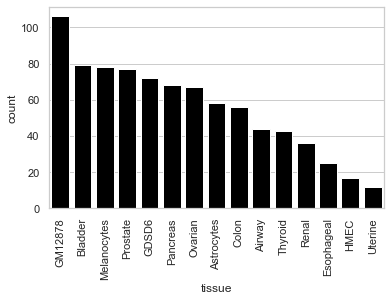

In [161]:
sns.set(style="whitegrid")
ax = sns.barplot(data=vocab_counts, x='tissue', y='count',color='black')
plt.xticks(rotation=90)
plt.subplots_adjust(top=1, bottom=.3)
plt.savefig(os.path.join(save_dir,'normal_tissue_vocab_counts.pdf'))

### upset plot

,tissue,num_instance,label
vocab,,,
AR::KLF12,Astrocytes,22,expr_loop_tissue
AR::KLF3,Astrocytes,18,expr_loop_tissue
AR::KLF5,Astrocytes,9,expr_loop_tissue
AR::SP2,Astrocytes,118,expr_pro_tissue|expr_loop_tissue
AR::ZNF281,Astrocytes,21,expr_loop_tissue
...,...,...,...
ZNF333::ZNF589,Melanocytes,20,expr_loop_tissue
ZNF384::ZNF816,Pancreas,13,expr_loop_tissue
ZNF586::ZNF589,GM12878,195,expr_pro_tissue|expr_loop_tissue


GM12878        106
Bladder         79
Melanocytes     78
Prostate        77
GDSD6           72
Pancreas        68
Ovarian         67
Astrocytes      58
Colon           56
Airway          44
Thyroid         43
Renal           36
Esophageal      25
HMEC            17
Uterine         12
Name: tissue, dtype: int64


{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7f89b85dc350>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7f8968703250>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7f8a08c4d750>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7f89c8a3be10>}

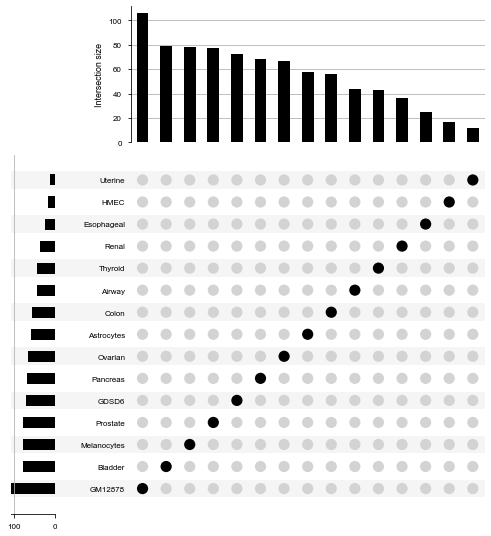

In [3]:
plt.style.use('seaborn-paper')

vocab_tissue_all_filt = pd.read_csv(os.path.join(save_dir, 'all_normal_tissues_vocab_summary.csv'),index_col=0)
all_normal = vocab_tissue_all_filt.groupby('vocab').agg({'tissue': '|'.join,'num_instance':sum, 'label': lambda x: '|'.join(list(set(x)))})
display(all_normal)
tissue_counts = all_normal.tissue.value_counts()
print(tissue_counts)
names = [x.split('|') for x in tissue_counts.index]
values = list(tissue_counts.values)

data_upset = from_memberships(names, data=values)
plot(data_upset)
# plt.savefig(os.path.join(save_dir, 'vocabs_cancer_upset.pdf'))

# numbers
``` 
### of all regulatory TF vocabulary motifs occur pairwise within the same promoter region (Intra-promoter), #### occur pairwise within the same enhancer region (Intra-Enhancer), and #### occur with one motif residing in a distal enhancer region and the paired motif residing in the looped target gene promoter (Inter-Enhancer-Promoter) 

```

In [20]:
vocab_tissue_all_filt = pd.read_csv(os.path.join(save_dir, 'all_normal_tissues_vocab_summary.csv'),index_col=0)
vocab_tissue_all_filt[:5]

,label,num_instance,tf1,tf2,tissue,vocab
0,expr_loop_tissue,17,NaN,NaN,Airway,ARID5B::NKX2-1
1,expr_loop_tissue,41,NaN,NaN,Airway,ARID5B::NR1D1
2,expr_pro_tissue|expr_loop_tissue,119,NaN,NaN,Airway,ARID5B::TBX1
3,expr_pro_tissue|expr_loop_tissue,85,NaN,NaN,Airway,BARX2::FOXJ2
4,expr_loop_tissue,41,NaN,NaN,Airway,BARX2::FOXK1


In [21]:
save_dir

'../data/processed/fig4_modelling/vocab_sum/'

In [28]:
tf_tf_loop_type_files = glob.glob('../data/processed/fig4_modelling/tf_tf_pairs/expr*loop_type.csv')
tissue_loop_df_dict={}
for file in tf_tf_loop_type_files:
    tissue = os.path.basename(file).split('_')[1]
    print(tissue, file)
    tissue_loop_df_dict[tissue] = pd.read_csv(file,index_col=0).fillna('')
    
# pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs/expr_Astrocytes_loop_type.csv',index_col=0)


Astrocytes ../data/processed/fig4_modelling/tf_tf_pairs/expr_Astrocytes_loop_type.csv
GM12878 ../data/processed/fig4_modelling/tf_tf_pairs/expr_GM12878_loop_type.csv
Thyroid ../data/processed/fig4_modelling/tf_tf_pairs/expr_Thyroid_loop_type.csv
GDSD0 ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD0_loop_type.csv
Esophageal ../data/processed/fig4_modelling/tf_tf_pairs/expr_Esophageal_loop_type.csv
Prostate ../data/processed/fig4_modelling/tf_tf_pairs/expr_Prostate_loop_type.csv
GDSD3 ../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD3_loop_type.csv
Colon ../data/processed/fig4_modelling/tf_tf_pairs/expr_Colon_loop_type.csv
Airway ../data/processed/fig4_modelling/tf_tf_pairs/expr_Airway_loop_type.csv
Bladder ../data/processed/fig4_modelling/tf_tf_pairs/expr_Bladder_loop_type.csv
Melanocytes ../data/processed/fig4_modelling/tf_tf_pairs/expr_Melanocytes_loop_type.csv
Uterine ../data/processed/fig4_modelling/tf_tf_pairs/expr_Uterine_loop_type.csv
Pancreas ../data/processed/fig4_

In [30]:
vocab_tissue_all_filt['num_genes_pro_pro'] = 0 
vocab_tissue_all_filt['num_genes_pro_loop'] = 0 
vocab_tissue_all_filt['num_genes_loop_loop'] = 0 
vocab_tissue_all_filt['num_genes_all_config'] = 0 
for idx, row in vocab_tissue_all_filt.iterrows():
    df = tissue_loop_df_dict[row['tissue']]
    info = df.loc[row['vocab']]
    genes_all = set(info.pro_pro_genes.split('|')).union(set(info.pro_loop_genes.split('|'))).union(set(info.loop_loop_genes.split('|')))
    vocab_tissue_all_filt.at[idx,'num_genes_pro_pro'] = info['pro_pro_count']
    vocab_tissue_all_filt.at[idx,'num_genes_pro_loop'] = info['pro_loop_count']
    vocab_tissue_all_filt.at[idx,'num_genes_loop_loop'] = info['loop_loop_count']
    vocab_tissue_all_filt.at[idx,'num_genes_all_config'] = len(genes_all)

In [32]:
vocab_tissue_all_filt.sum()

label                   expr_loop_tissueexpr_loop_tissueexpr_pro_tissu...
num_instance                                                        59130
tissue                  AirwayAirwayAirwayAirwayAirwayAirwayAirwayAirw...
vocab                   ARID5B::NKX2-1ARID5B::NR1D1ARID5B::TBX1BARX2::...
num_genes_pro_pro                                                    6143
num_genes_pro_loop                                                  16445
num_genes_loop_loop                                                331915
num_genes_all_config                                               333658
frac_genes_pro_pro                                                15.1136
frac_genes_loop_loop                                              832.456
frac_genes_pro_loop                                                40.118
dtype: object

In [36]:

config_df = vocab_tissue_all_filt[['num_genes_pro_pro','num_genes_pro_loop','num_genes_loop_loop'	]]
config_df = config_df>0
config_df.sum()/config_df.shape[0]

num_genes_pro_pro      0.945107
num_genes_pro_loop     0.984487
num_genes_loop_loop    1.000000
dtype: float64

In [37]:
                        
# vocab_tissue_all_filt['frac_genes_pro_pro'] = vocab_tissue_all_filt['num_genes_pro_pro']/vocab_tissue_all_filt['num_genes_all_config']
# vocab_tissue_all_filt['frac_genes_loop_loop'] = vocab_tissue_all_filt['num_genes_loop_loop']/vocab_tissue_all_filt['num_genes_all_config']
# vocab_tissue_all_filt['frac_genes_pro_loop'] = vocab_tissue_all_filt['num_genes_pro_loop']/vocab_tissue_all_filt['num_genes_all_config']
 
# vocab_tissue_all_filt['frac_genes_pro_pro_wt'] = vocab_tissue_all_filt['num_genes_pro_pro']*2*vocab_tissue_all_filt['weighting_factor']
# vocab_tissue_all_filt['frac_genes_loop_loop_wt'] = vocab_tissue_all_filt['num_genes_loop_loop']
# vocab_tissue_all_filt['frac_genes_pro_loop_wt'] = vocab_tissue_all_filt['num_genes_pro_loop']*vocab_tissue_all_filt['weighting_factor']
# vocab_tissue_all_filt['num_genes_all_config_wt'] = vocab_tissue_all_filt['frac_genes_pro_pro_wt'] + vocab_tissue_all_filt['frac_genes_loop_loop_wt'] + vocab_tissue_all_filt['frac_genes_pro_loop_wt']
# vocab_tissue_all_filt['frac_genes_pro_pro_wt'] = vocab_tissue_all_filt['frac_genes_pro_pro_wt']/vocab_tissue_all_filt['num_genes_all_config_wt']
# vocab_tissue_all_filt['frac_genes_loop_loop_wt'] = vocab_tissue_all_filt['frac_genes_loop_loop_wt']/vocab_tissue_all_filt['num_genes_all_config_wt']
# vocab_tissue_all_filt['frac_genes_pro_loop_wt'] = vocab_tissue_all_filt['frac_genes_pro_loop_wt']/vocab_tissue_all_filt['num_genes_all_config_wt']
 
             